# Project 5, Vehicle Detection 

In [2]:
#import libraries

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pickle
import time

from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from scipy.misc import imresize
from collections import deque


In [96]:
#These functions are defined in the udacity leassons

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [4]:
#Get the vehicle images file names
vehicles_files = glob.glob('vehicles/**/*.png')

#Get the non vehicle images file names
non_vehicles_files = glob.glob('non-vehicles/**/*.png')
print('Vehicles= ',len(vehicles_files), 'Non vehicles= ',len(non_vehicles_files))

Vehicles=  8792 Non vehicles=  8968


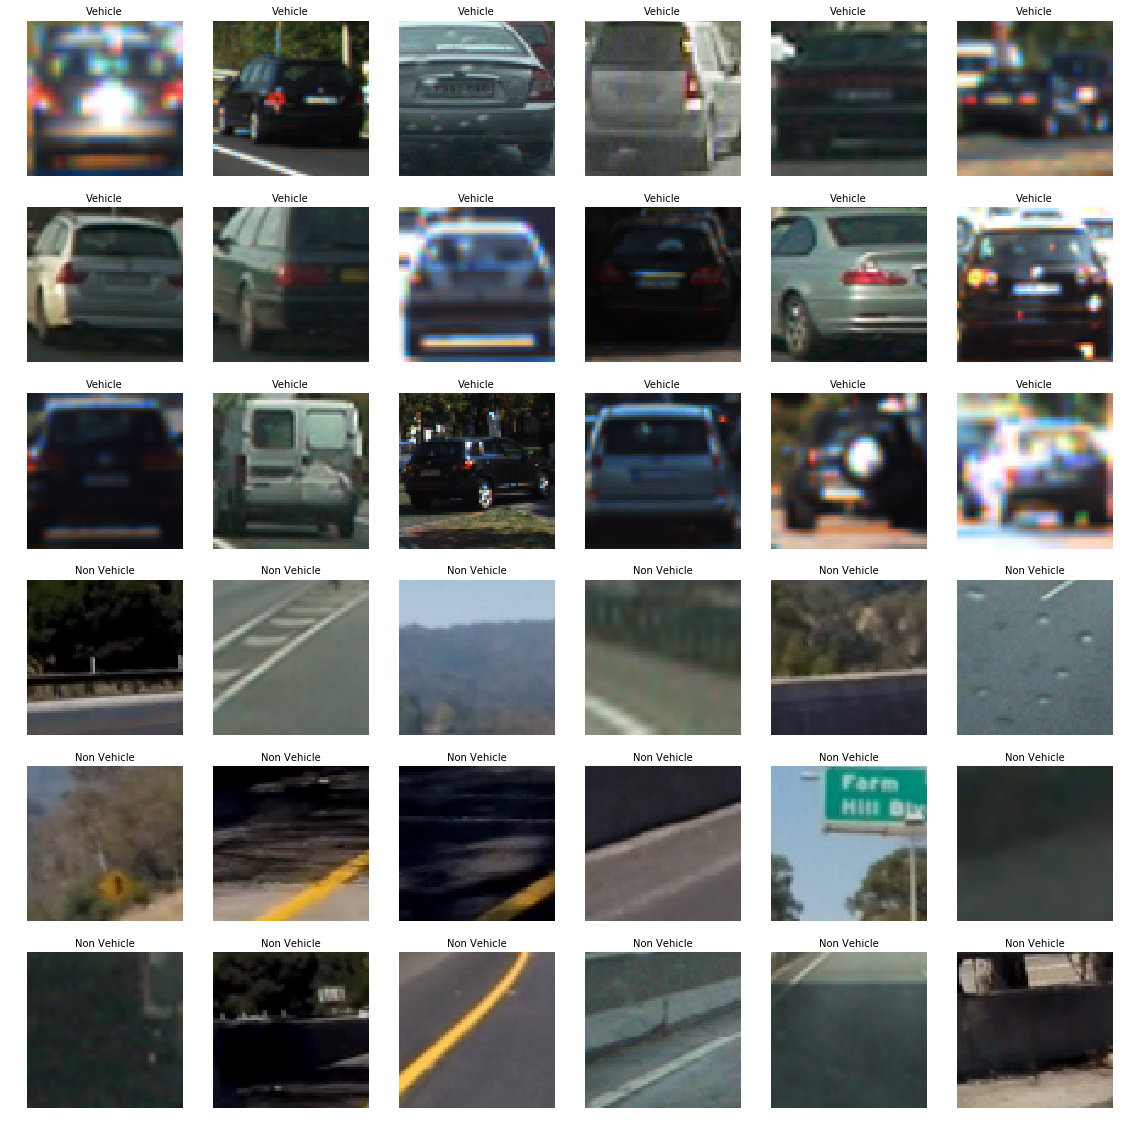

In [5]:

fig, axs = plt.subplots(6,6, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

#show a sample of vehicles images
for i in np.arange(18):
    ind=np.random.randint(0,len(vehicles_files))
    img = cv2.imread(vehicles_files[ind])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Vehicle', fontsize=10)
    axs[i].imshow(img)
    
#show a sample of non vehicles images
for i in np.arange(18,36):
    ind= np.random.randint(0,len(non_vehicles_files))
    img = cv2.imread(non_vehicles_files[ind])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Non Vehicle', fontsize=10)
    axs[i].imshow(img)

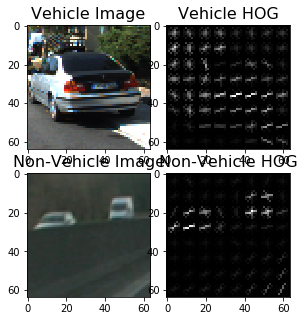

In [101]:
#Hog features

#HOG features of a vehicle image
ind=np.random.randint(0,len(vehicles_files))
car_image = mpimg.imread(vehicles_files[ind])
_, car_dst = get_hog_features(car_image[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

#HOG features of non vehicle image
ind=np.random.randint(0,len(vehicles_files))
noncar_image = mpimg.imread(non_vehicles_files[ind])
_, noncar_dst = get_hog_features(noncar_image[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Show the images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5,5))
#f.subplots_adjust(hspace = .4, wspace=.2)

#fig, axs = plt.subplots(6,6, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

ax1.imshow(car_image)
ax1.set_title('Vehicle Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Vehicle HOG', fontsize=16)
ax3.imshow(noncar_image)
ax3.set_title('Non-Vehicle Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Vehicle HOG', fontsize=16)

In [7]:
#This function is based from the Udacity lessons

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [8]:
#Feature extraction parameters

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
hog_channel = 'ALL'
color_space = 'YCrCb'

spatial_feat = True
hist_feat = True
hog_feat = True

In [9]:
#Extract features
car_features = extract_features(vehicles_files, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(non_vehicles_files, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

/Users/carlos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [10]:
#separate data in train and test data

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)



In [12]:
# Use a linear Support Vector Classification
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
print("Training SVC Classifier...")
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'seconds to train SVC.')

Training SVC Classifier...
21.39 seconds to train SVC.


In [13]:
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
0.01511 seconds to predict 10 labels with SVC


In [14]:
t=time.time()
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t2 = time.time()
print(round(t2-t, 5), 'seconds to compute the test accuracy.')

Test Accuracy of SVC =  0.9862
0.69847 seconds to compute the test accuracy.


In [15]:
#This function was defined in the Udacity lessons

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [16]:
#This function was defined in the Udacity lessons

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [17]:
#This function was defined in the Udacity lessons

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [18]:
#This function was defined in the Udacity lessons

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



/Users/carlos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


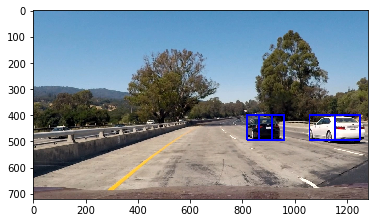

In [19]:
y_start_stop = [350, None] # Min and max in y to search in slide_window()

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [22]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #print('find cars')
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    imshape= img.shape
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    spatial_features=[]
    hist_features= []
    test_prediction= []
    hog_features=[]
    
    box_list= []
    j=0
    #print('nxsteps= ',nxsteps,' nysteps=',nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_feat:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                
            if hist_feat:     
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #print(test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box= ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart))
                #print(box)
                if xbox_left+ (win_draw/2) > 300:
                    box_list.append(box)
                #box_list.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                #print('test_prediction=1')
                
            #if np.int(xleft*scale) > 820:
            #    xbox_left = np.int(xleft*scale)
            #    ytop_draw = np.int(ytop*scale)
            #    win_draw = np.int(window*scale)
            #    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)
             #   #print('xlef= ',xbox_left,', ytop= ',ytop_draw+ystart, 'w= ',xbox_left+win_draw, 'h= ',ytop_draw+win_draw+ystart)
             #   j= j+1
             #   print(test_features)
             #   print('xbox_left= ',xbox_left)
            
            #if j>0:
             #   return draw_img

    return box_list

/Users/carlos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


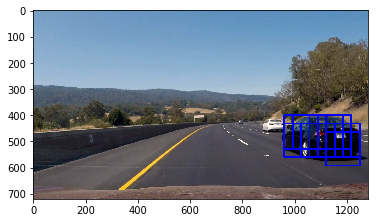

In [47]:
#img = mpimg.imread('test_images/test6.jpg')
img = mpimg.imread('video_frames/750.jpg')


ystart = 400
ystop = 656
scale = 1.5

draw_image = np.copy(image)    
#box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
#                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

#ystart = 400
#ystop = 500
#scale = 1
#box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
#                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

ystart = 400
ystop = 700
scale = 2
box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)



draw_image= draw_boxes(img, box_list)
plt.imshow(draw_image)

In [48]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes0(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], color=(0,0,255), 6)
        img = draw_boxes(img, [bbox], color=(0, 0, 255), thick=6)
    # Return the image
    return img

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        img = draw_boxes(img, [bbox], color=(0, 0, 255), thick=6)
    # Return the image
    return img

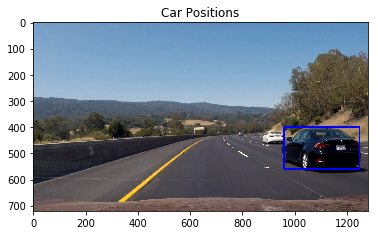

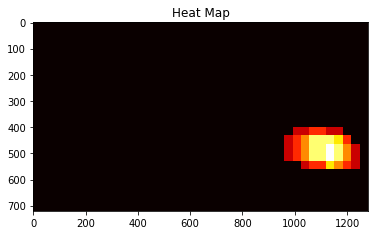

In [49]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions')
plt.figure()
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

In [27]:
#These function is based on Udacity lesson,
#The function finds a car with a single scale
def detect_vehicles(image):

    box_list= find_cars(image, ystart,ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    

/Users/carlos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


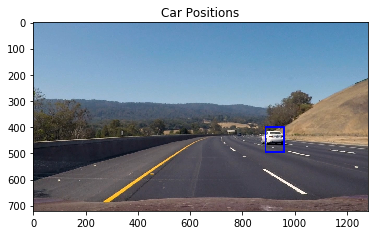

In [28]:
img = mpimg.imread('test_images/test3.jpg')
output = detect_vehicles(img)
plt.figure()
plt.imshow(output)
plt.title('Car Positions')

In [58]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:
test_video_output = "./test_video_output.mp4"
clip1 = VideoFileClip("./test_video.mp4")
white_clip1 = clip1.fl_image(detect_vehicles)
%time white_clip1.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ./test_video_output.mp4
[MoviePy] Writing video ./test_video_output.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  2.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output.mp4 

CPU times: user 50.1 s, sys: 1.54 s, total: 51.6 s
Wall time: 13.7 s


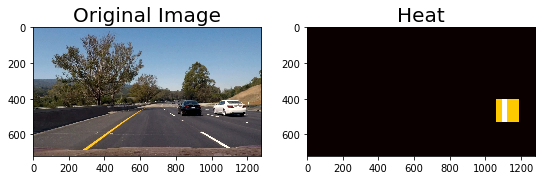

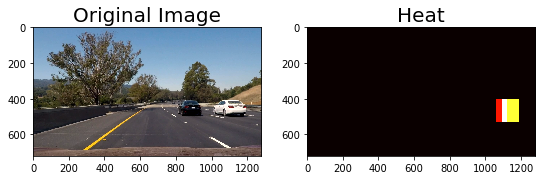

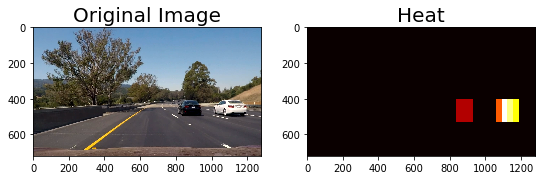

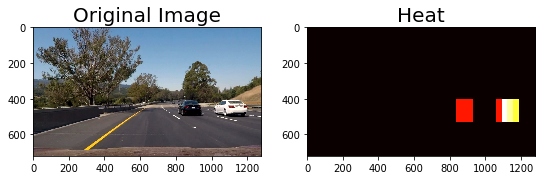

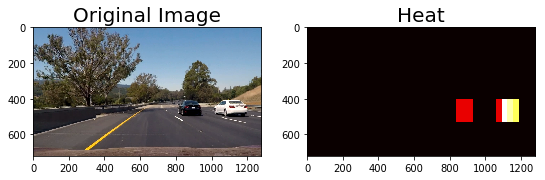

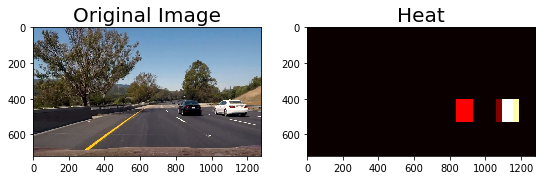

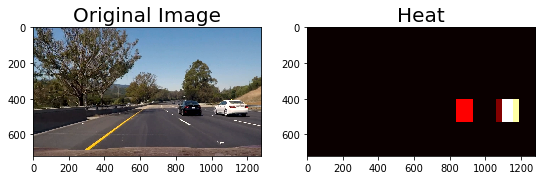

In [70]:
#In this section I implment a method that computes the average heat of 10 five frames
heats= deque(maxlen=5)

vc = cv2.VideoCapture('test_video.mp4')
rval= True


draw_image = np.copy(image)    
    
i=0    
while rval:
    rval, img = vc.read()
    img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    heat0 = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat0 = add_heat(heat0,box_list)
    # Apply threshold to help remove false positives
    heat0 = apply_threshold(heat0,1)  
    heats.append(heat0)
    heat= np.mean(heats,axis=0)
    
    #print(heat0)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    #draw_image= process(img)
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img)
    ax2.set_title('Heat', fontsize=20)
    #ax2.imshow(draw_image)
    ax2.imshow(heatmap, cmap='hot')
    
    if i>5:
        break
    i=i+1


In [60]:
def detect_vehicles2(image):

    ystart = 400
    ystop = 656
    scale = 1.5
    box_list= find_cars(image, ystart,ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 400
    ystop = 500
    scale = 1
    box_list0= find_cars(image, ystart,ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list= box_list + box_list0
    
    ystart = 400
    ystop = 700
    scale = 2
    box_list0= find_cars(image, ystart,ystop, scale, svc, X_scaler, orient, 
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list= box_list + box_list0
    
    #print(len(box_list))
    
    if (len(box_list)>1):
        heat0 = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat0 = add_heat(heat0,box_list)
        # Apply threshold to help remove false positives
        heat0 = apply_threshold(heat0,1)  
        heats.append(heat0)
    
    if (len(heats)>0):
        heat= np.mean(heats,axis=0)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    else:
        draw_img= image

    return draw_img

/Users/carlos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


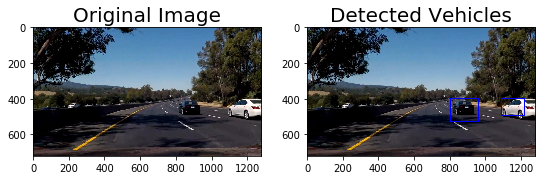

In [61]:
heats= deque(maxlen=10)
#begin=550

begin=1040
end= begin + 10
for i in range(begin,end):
    file = './video_frames/'+str(i)+'.jpg'
    img = mpimg.imread(file)
    
    #draw_image=detect_vehicles(img)
    draw_image=detect_vehicles2(img)

    #draw_image= process(img)
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img)
    ax2.set_title('Detected Vehicles', fontsize=20)
    ax2.imshow(draw_image)
    
    break



/Users/carlos/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


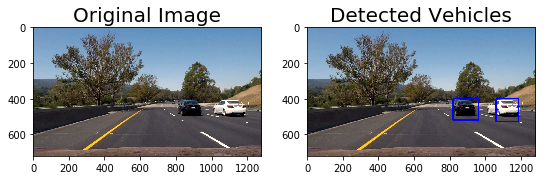

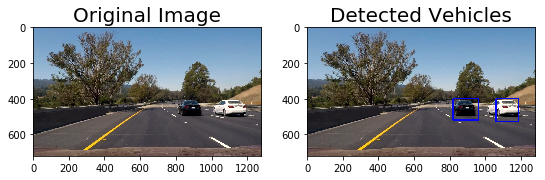

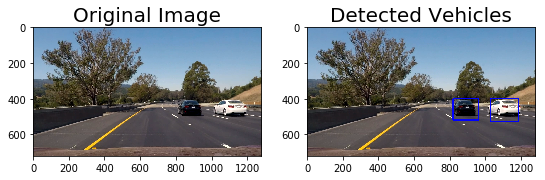

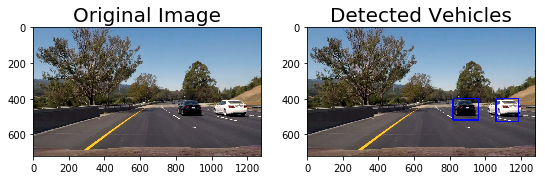

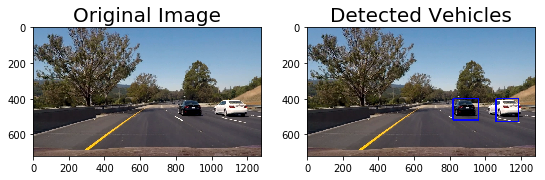

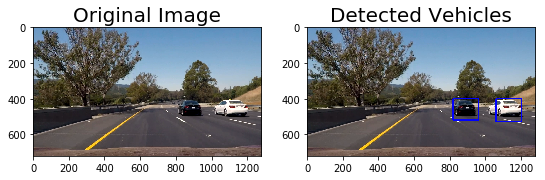

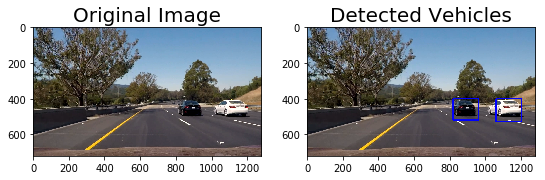

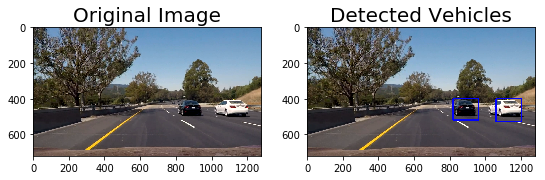

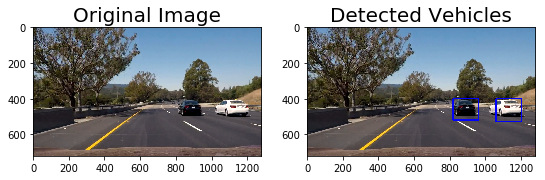

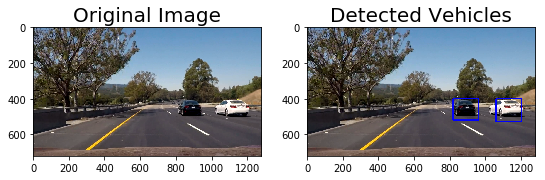

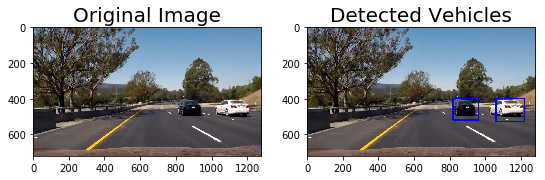

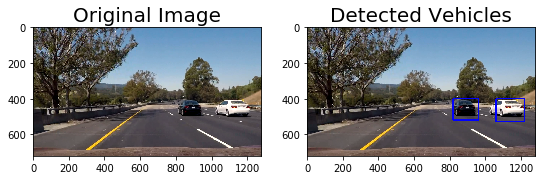

In [62]:
heats= deque(maxlen=10)

#vc = cv2.VideoCapture('project_video.mp4')
vc = cv2.VideoCapture('test_video.mp4')

rval= True
draw_image = np.copy(image)    
    
i=0    
while rval:
    rval, img = vc.read()
    img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    draw_img=detect_vehicles2(img)
    
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img)
    ax2.set_title('Detected Vehicles', fontsize=20)
    ax2.imshow(draw_img)
    
    if i>10:
        break
    i=i+1



In [64]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [65]:
heats= deque(maxlen=5)

test_video_output = "./test_video_output2.mp4"
clip1 = VideoFileClip("./test_video.mp4")
white_clip1 = clip1.fl_image(detect_vehicles2)
%time white_clip1.write_videofile(test_video_output, audio=False)


[MoviePy] >>>> Building video ./test_video_output2.mp4
[MoviePy] Writing video ./test_video_output2.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output2.mp4 

CPU times: user 1min 51s, sys: 3.5 s, total: 1min 55s
Wall time: 29.5 s


In [68]:
heats= deque(maxlen=10)

test_video_output = "./project_video_output2.mp4"
clip1 = VideoFileClip("./project_video.mp4")
#white_clip1 = clip1.fl_image(detect_vehicles2).subclip(40,50)
white_clip1 = clip1.fl_image(detect_vehicles2)

%time white_clip1.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output2.mp4
[MoviePy] Writing video ./project_video_output2.mp4


100%|█████████▉| 1260/1261 [18:11<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output2.mp4 

CPU times: user 1h 6min 25s, sys: 2min 41s, total: 1h 9min 7s
Wall time: 18min 12s
